In [1]:
%matplotlib inline

import gym
import torch
from torch import nn
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt

## Create Environment using GYM

In [2]:
env = gym.make('CartPole-v1')

state_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

print('Env Created:\nState Size: %d\tActions Size: %d' %(state_space_size, action_space_size))

Env Created:
State Size: 4	Actions Size: 2


## Create Agent -> A simple Q network

In [79]:
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, lr):
        super(DQNAgent, self).__init__()
        
        # craete network
        self.q_network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        self.mse_func = nn.MSELoss()
        
    def get_values(self, state):
        '''  
        return state,action values (expected rewards)
        '''
        state = torch.tensor([state])
        
        return self.q_network(state)
    
    def update_q_network(self, experiences, gamma, batch_size=32):
        '''
        experiences = [s, a, s', r, done]
                       0  1  2   3    4
        '''
        if len(experiences) < batch_size:
            return 0.0
        
        # sample mini batch from experiences (batch_size=32)
        experiences_idx = np.random.choice(list(range(len(experiences))), batch_size)
                
        y_true = []
        y_hat = []
    
        for exp_id in experiences_idx:
            current_state, action, next_state, reward, done = experiences[exp_id]
            
            # calculate Y true
            if done:
                y_true.append(reward)
            else:
                next_q_value = self.q_network(torch.tensor([next_state]))
                y_true.append(reward + gamma * torch.max(next_q_value).item())

            # calculate Y hat
            y_hat.append(self.q_network(torch.tensor([current_state]))[:, action])

        # use simple MSE
        for pred, targ in zip(y_hat, y_true):            
            self.optimizer.zero_grad()
            
            # loss = self.mse_func(pred, targ)
            loss = torch.pow(pred - targ, 2)
            loss.backward()
            
            self.optimizer.step()

        return loss.item()

## Training part

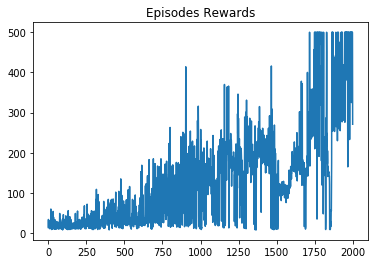

In [140]:
GAMMA           = 0.99
LR              = 0.001
MAX_EPISODES    = 2000
EPSILON         = 1.0
EPS_DECAY       = 0.992
MAX_MEMORY_LEN  = 1000

agent = DQNAgent(state_space_size, action_space_size, 100, LR).double()
memory = []
episode_rewards = []

agent.train()

for episode_no in range(MAX_EPISODES):
    rewards = []
    
    done = False
    current_state = env.reset()
    
    # go through an episode
    while not done:
        # get action
        q_values = agent.get_values(current_state)
        
        # select an action using e-greedy
        if np.random.random(1)[0] < EPSILON:
            action = np.random.randint(action_space_size)
        else:
            action = torch.argmax(q_values).item()
        
        # perform action
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        reward = reward if not done else -reward
        
        # save experience in memory
        if len(memory) < MAX_EPISODES:
            memory.append((
                current_state, action, next_state, reward, done
            ))
        else:
            memory = memory[1:]
            memory.append((
                current_state, action, next_state, reward, done
            ))
        
        # go next
        current_state = next_state

        
    # update the agent 
    loss_value = agent.update_q_network(memory, GAMMA)
        
    if episode_no % 8 == 0:
        EPSILON *= EPS_DECAY
        EPSILON = max(EPSILON, 0.01)
            
    # print 
    episode_rewards.append(np.sum(rewards))
    
    if episode_no % 50 == 0:
        print('[%d/%d]   Mean Reward = %0.2f   Max Reward = %d    EPS = %0.3f\t\t\t' %(episode_no, MAX_EPISODES, np.mean(episode_rewards[-50:]), np.max(episode_rewards[-50:]), EPSILON), end='\r', flush=True)
        
# plot each episode's total reward
plt.plot(episode_rewards)
plt.title('Episodes Rewards')
plt.show()

## Test the agent

In [141]:
agent.eval()
done = False
current_state = env.reset()
rewards = []

# go through an episode
while not done:
    # render env
    env.render()
    
    # get BEST action based on the log probabilities -> argmax on them
    q_values = agent.get_values(current_state)
    action = torch.argmax(q_values).item()
    
    # perform action
    next_state, reward, done, _ = env.step(action)

    rewards.append(reward)
    
    current_state = next_state
    
env.close()

print('Total Reward = %d' %(np.sum(rewards)))

Total Reward = 393


In [142]:
# benchmark!
agent.eval()
episode_rewards = []

for i in range(100):
    done = False
    current_state = env.reset()
    rewards = []

    # go through an episode
    while not done:
        # get BEST action based on the log probabilities -> argmax on them
        q_values = agent.get_values(current_state)
        action = torch.argmax(q_values).item()

        # perform action
        next_state, reward, done, _ = env.step(action)

        rewards.append(reward)

        current_state = next_state

    episode_rewards.append(np.sum(rewards))
    
print('Min = %d   Max = %d   Mean = %0.2f' %(np.min(episode_rewards), np.max(episode_rewards), np.mean(episode_rewards)))

if np.min(episode_rewards) > 198:
    print('Solved :)')

Min = 291   Max = 500   Mean = 469.62
Solved :)
